**Название проекта**

Стратегия взаимодействия с клиентами в сети фитнес-центров "Культурист-датасаентист"
_____
**Описание исследования.**
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 

_____
**Цель исследования.**
Провести анализ и подготовить план действий по удержанию клиентов

_____
**Задачи исследования.**
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами: 
 * 1) выделить целевые группы клиентов;
 * 2) предложить меры по снижению оттока;
 * 3) определить другие особенности взаимодействия с клиентами.

**Исходные данные.**
    
Набор данных включает следующие поля:
*	Данные клиента за предыдущий до проверки факта оттока месяц: 
 * 'gender' — пол;
 * 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
 * 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
 * Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
 * 'Phone' — наличие контактного телефона;
 * 'Age' — возраст;
 * 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
*	Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента: 
 * 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
 * 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
 * 'Group_visits' — факт посещения групповых занятий;
 * 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
 * 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
 * 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
*	'Churn' — факт оттока в текущем месяце.



______

**Данное исследование разделим на несколько частей:**

* [Изучение общей информации](#main_info)
* [Исследовательский анализ данных (EDA)](#eda)
* [Построим модель прогнозирования оттока клиентов](#build_model)
* [Сделаем кластеризацию клиентов](#clustering)
* [Вывод](#summary)

<a id='main_info'></a>
## Изучение общей информации

**В этом шаге:**
* подключим библиотеки
* откроем и просмотрим файлы, необходимые для работы

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
data = pd.read_csv('gym_churn.csv')
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [3]:
data.columns = data.columns.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

**Вывод по шагу:** Библиотеки подключены, данные получены, стобцы приведени к правильному виду

<a id='eda'></a>
## Исследовательский анализ данных (EDA)

**На этолм шаге**
* Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения
* Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
* Постройм столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
* Постройм матрицу корреляций и отобразим её.

Посмотрим на датасет: есть ли на первый взгляд явные аномалии, отсутствующие признаки

In [1]:
# выведем уникальные значения по всем столбцам - посмотрим есть ли на первый взгляд явные аномалии
def show_data_values(data):
    for col in data.columns:    
        try:
            values = sorted(data[col].unique())
            # если больше 12 значений, выведем только первые и последние 6
            if len(values) > 12:
                display (col, values[:6], values[-6:])
            else: display(col, values)
        except:
            display(f'После except: {col}', data[col].unique())               
    

In [5]:
show_data_values(data)

'gender'

[0, 1]

'near_location'

[0, 1]

'partner'

[0, 1]

'promo_friends'

[0, 1]

'phone'

[0, 1]

'contract_period'

[1, 6, 12]

'group_visits'

[0, 1]

'age'

[18, 19, 20, 21, 22, 23]

[35, 36, 37, 38, 39, 41]

'avg_additional_charges_total'

[0.1482047884566242,
 0.1718623034294992,
 0.2516057215197094,
 0.3348235683106111,
 0.3621530981063579,
 0.4108930359215179]

[476.4326553201213,
 488.7081749435304,
 496.1722220804551,
 515.392605727715,
 534.2561818694521,
 552.5907403868798]

'month_to_end_contract'

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]

'lifetime'

[0, 1, 2, 3, 4, 5]

[23, 24, 26, 27, 29, 31]

'avg_class_frequency_total'

[0.0,
 0.0027603929467316,
 0.0064356961313476,
 0.0088238849200099,
 0.0113607681657801,
 0.0147099999751787]

[4.953290171906938,
 5.079241818217404,
 5.14185240354786,
 5.410054460060277,
 5.4218977080804205,
 6.02366847599591]

'avg_class_frequency_current_month'

[0.0,
 0.0028723624189406,
 0.0032735656800802,
 0.0044478774945923,
 0.0054923781012502,
 0.0063979878928257]

[4.962539709845446,
 4.976679932267676,
 5.024720933352363,
 5.3684153086386734,
 5.4582946563023285,
 6.146782880452392]

'churn'

[0, 1]

In [6]:
display('Пропуски по полям:', data.isna().sum())

'Пропуски по полям:'

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [7]:
print('Явных дубликатов:', data.duplicated().sum())

Явных дубликатов: 0


***Вывод:*** Явных аномалий не выявлено, дубликаты и пропуски отсутствуют

Посмотрим средние значения и стандартные отклонения

In [8]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [9]:
display('Средние значения признаков в двух группах')

churn_0 = data[data['churn'] == 0]
churn_1 = data[data['churn'] == 1]

pd.DataFrame({'Field_name' : data.columns, 'churn_0' : churn_0.mean().values,\
              'churn_1' : churn_1.mean().values})

'Средние значения признаков в двух группах'

,Field_name,churn_0,churn_1
0,gender,0.51,0.51
1,near_location,0.87,0.77
2,partner,0.53,0.36
3,promo_friends,0.35,0.18
4,phone,0.90,0.90
5,contract_period,5.75,1.73
6,group_visits,0.46,0.27
7,age,29.98,26.99
8,avg_additional_charges_total,158.45,115.08
9,month_to_end_contract,5.28,1.66


***Вывод:*** Посмотрев на средние значения уже можем выделить явно самые разнящиеся параметры у клиентов ушедших в отток и оставшихся: длительность текущего абонемента, срок до окончания текущего действующего абонемента, время с момента первого обращения в фитнес-центр, а также запись в клуб по акции «приведи друга». 

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

Построим столбчатые гистограммы для столбцов с дискретными величинами

'Столбчатые гистограммы для столбцов с дискретными величинами'

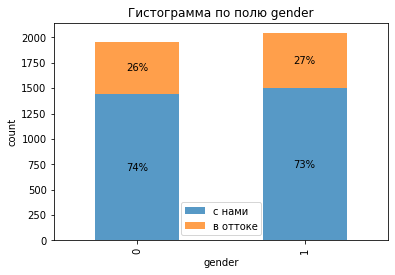

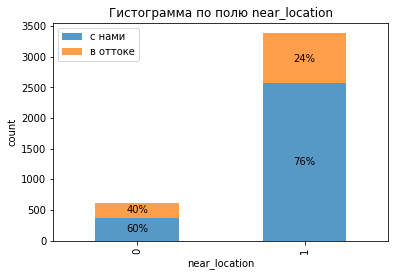

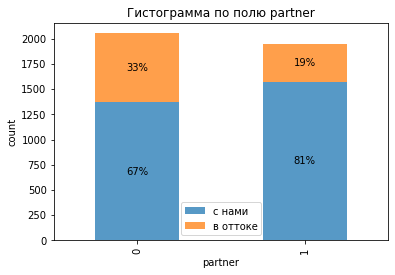

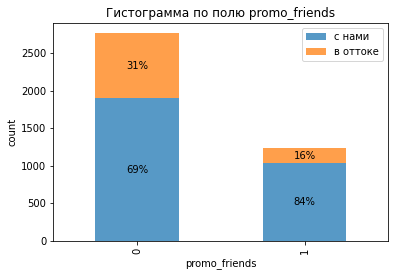

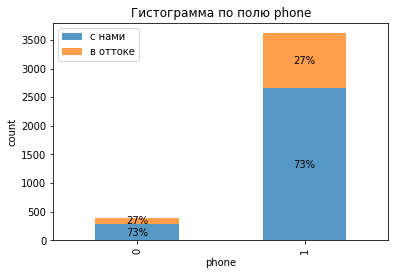

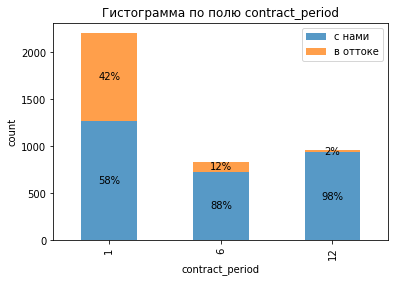

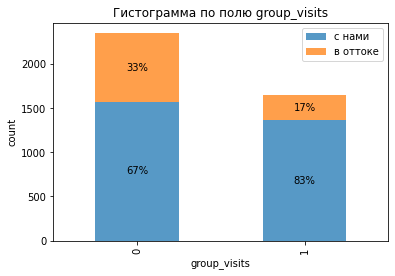

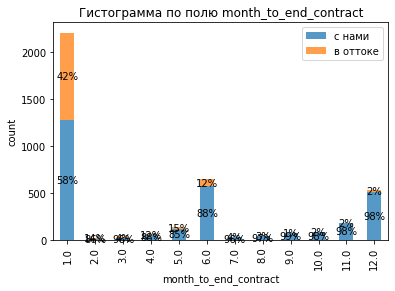

In [10]:
display('Столбчатые гистограммы для столбцов с дискретными величинами')

discrete_cols = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', \
                 'contract_period', 'group_visits', 'month_to_end_contract']

# метод напишет проценты в переданных столбцах
def set_bars_percent(bars_in_stack, stack_height):
    for bar in bars_in_stack:             
            x = bar.get_x()
            y = bar.get_y()
            height = bar.get_height()
            width = bar.get_width()
            label_x = x + width / 2
            label_y = y + height / 2
            label_text = "{:0.0f}%".format(height / stack_height * 100)
            ax.text(label_x, label_y, label_text, ha='center',    
                    va='center')

# построим столбчатые гистограммы
for col in discrete_cols:       
    s0 = churn_0.groupby(col)['churn'].count()
    s1 = churn_1.groupby(col)['churn'].count()
    
    
    ax = pd.DataFrame({'name':s0.index, 'churn_0':s0.values, 'churn_1':s1.values})\
        .plot(kind = 'bar', x='name', stacked = True, alpha = 0.75)     
       
        
    # тут пишем проценты к столбцам. Проще не придумал как)    
    x_prev = 0
    bars_in_stack = []
    height_in_stack = 0    
    # отсортируем графики, чтобы в цикле столбцы подряд шли
    for bar in sorted(ax.patches, key=lambda x: x.get_x(), reverse=True):      
        x = bar.get_x()        
        
        # если bar из новой группы, то сделать надписи в собранной
        if x_prev != x and x_prev != 0:            
            set_bars_percent(bars_in_stack, height_in_stack) 
            bars_in_stack = []
            height_in_stack = 0
            x_prev = 0
        
        # добавляем bar в наш список
        if x_prev == x or x_prev == 0:
            x_prev = x
            bars_in_stack.append(bar)            
            height_in_stack += bar.get_height()    
            
    set_bars_percent(bars_in_stack, height_in_stack)

    
    
    plt.legend(['с нами', 'в оттоке'])
    plt.title('Гистограмма по полю ' + col)
    plt.ylabel('count')
    plt.xlabel(col)    
    plt.show();

***Вывод:*** 
Явно выделяющиеся закономерности:
* сотрудники компании-партнёра клуба реже уходят в отток
* самый большой отток (почти половина) у тех кто заключил контракт только на месяц, и практически отсутствует у тех кто заключил на год.
* по групповым занятиям отток значительно меньше у тех кто их посещает
* когда срок до окончания текущего действующего абонемента - 1 месяц шанс отвалиться максимальный. Похоже это напрямую зависит от контракта на месяц. Проверим позже


Построим гистограммы для столбцов с непрерывными величинами

'Гистограммы для столбцов с непрерывными величинами'

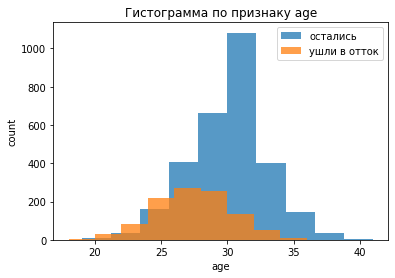

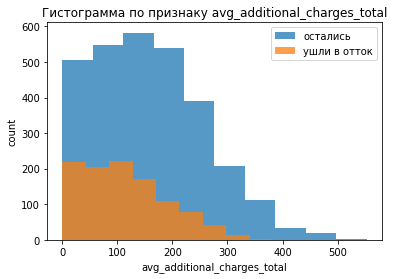

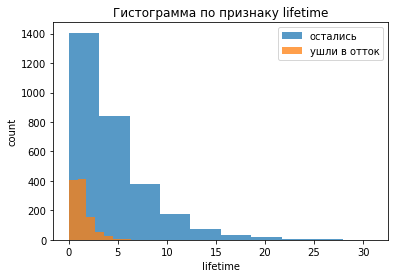

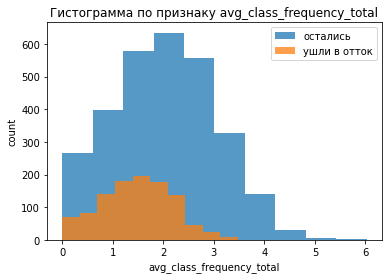

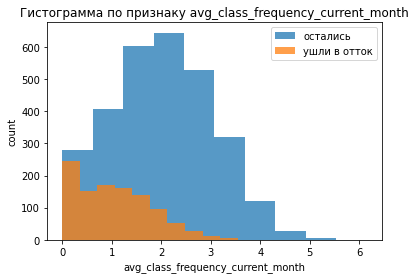

In [11]:
display('Гистограммы для столбцов с непрерывными величинами')

continuous_cols = ['age', 'avg_additional_charges_total', 'lifetime',\
                   'avg_class_frequency_total', 'avg_class_frequency_current_month']

for col in continuous_cols:
    plt.hist(churn_0[col], alpha = 0.75 )    
    plt.hist(churn_1[col], alpha = 0.75 )  
    plt.legend(['остались', 'ушли в отток'])
    plt.title('Гистограмма по признаку ' + col)
    plt.xlabel(col)
    plt.ylabel('count')
    
    plt.show() 

***Вывод:***
* при приближении к 30 летнему возрасту количество остающихся клиентов перевешивает уходящих и чем старше тем больше остающихся
* больше всего уходят клиенты в самый 1й месяц, в 2раза меньше во 2й, а вот те кто отзанимался больше 6 месяцев почти "не имеют шансов" покинуть наш фитнес-центр
* по средней частоте посещений число остающихся начинает значительно сильнее перевешивать от 2,5 и выше посещений в неделю за все время
* по средней частоте посещений за предыдущий месяц: больше всего отваливаются те, кто посетил меньше 2х раз

Построим матрицу корреляций

'Матрица корреляций признаков'

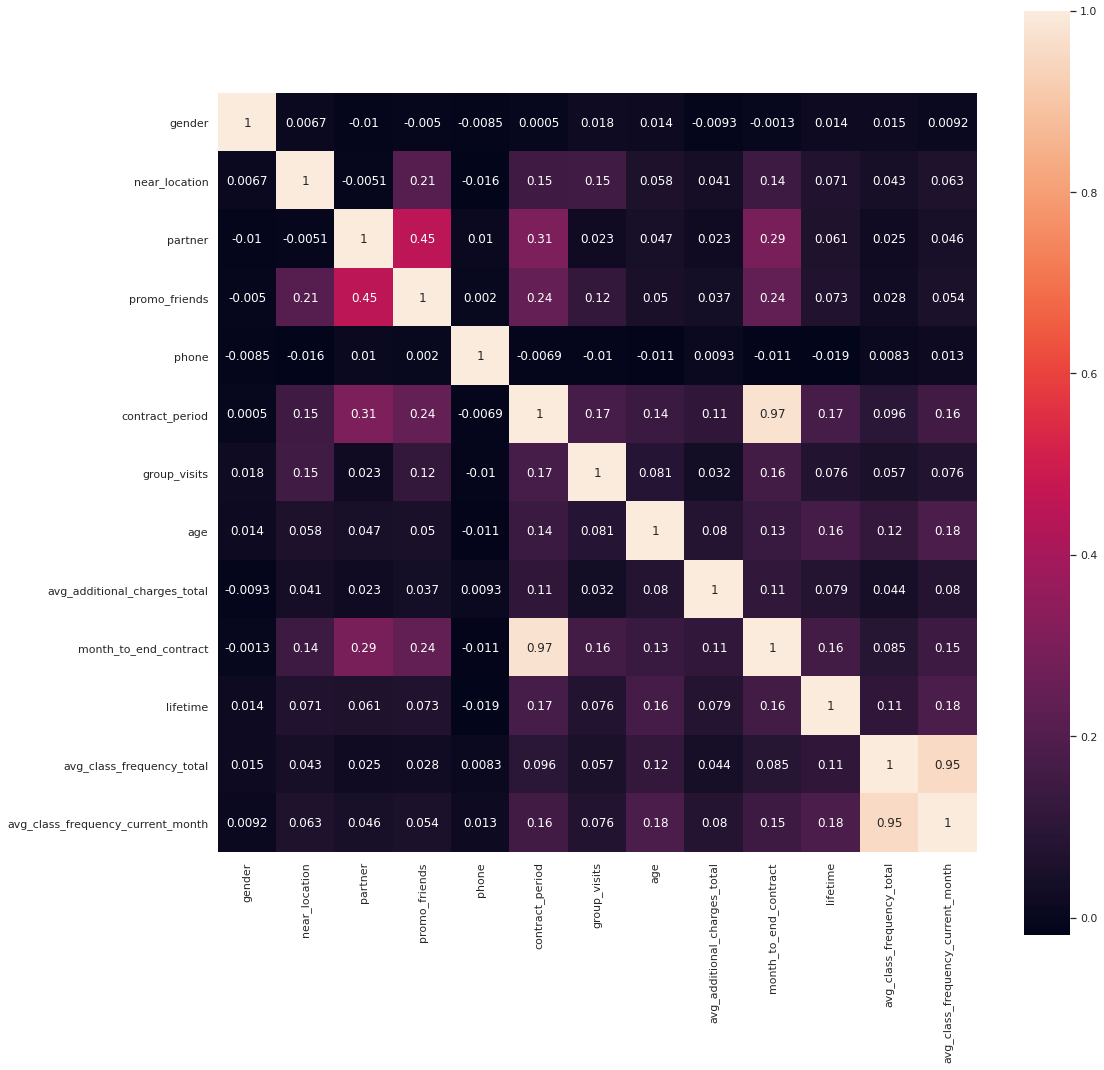

In [12]:
display('Матрица корреляций признаков')
sns.set(rc={'figure.figsize':(17, 17)})
sns.heatmap(data.drop('churn', axis=1).corr(), annot=True, square=True);

***Вывод:***
* видна почти прямая зависимость между периодом контракта и сроком до окончания текущего действующего периода.
* такая же почти прямая зависимочть между 'avg_class_frequency_total' и	'avg_class_frequency_current_month' 
* заметна некоторая корреляция между фактом записи в рамках акции  "Приведи друга" и сотрудничеством с компанией-пртнером клуба
* также есть небольшая корреляция сотрудничества с компанией-партнером и периодом контракта и соответственно и сроком до окончания


**Вывод по шагу** датасет изучили, построили столбчатые гистограммы и распределения признаков, построили матрицу корреляций


<div class="alert bg-primary"> <b>Комментарий студента:</b>
    Да, действительно - не заметил почему-то). Дописал в выводе и дальше в коде учел
</div>

<a id='build_model'></a>
## Построим модель прогнозирования оттока клиентов

**В этом шаге**
*	Разобъем данные на обучающую и валидационную выборку
*	Обучим модель на train-выборке двумя способами:
 *	логистической регрессией
 *	случайным лесом
*	Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели.


Разобъем данные на обучающую и валидационную выборку. Не будем   учитывать 'Month_to_end_contract' и 'Avg_class_frequency_total' , так как выше мы выяснили большую корреляцию с другими параметрами

In [13]:
X = data.drop(['churn', 'month_to_end_contract', 'avg_class_frequency_total'], axis=1)
y = data['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель на train-выборке логистической регрессией

In [14]:
lr_model = LogisticRegression(solver='liblinear', random_state = 0)
lr_model.fit(X_train, y_train)


# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test)
#lr_probabilities = lr_model.predict_proba(X_test)[:, 1]

lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision = precision_score (y_test, lr_predictions)
lr_recall = recall_score (y_test, lr_predictions)

Обучим модель на train-выборке случайным лесом

In [15]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model =  RandomForestRegressor(n_estimators = 100, random_state = 0)

# обучим модель случайного леса
rf_model.fit(X_train, y_train)
rf_predictions =  rf_model.predict(X_test).round()

rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score (y_test, rf_predictions)

Оценим наши модели по метрикам accuracy, precision и recall 

In [16]:
df_metrics = pd.DataFrame({"metric": ['accuracy', 'precision', 'recall'],\
                           'logistic_regression':[lr_accuracy, lr_precision, lr_recall],\
                           'random_forest':[rf_accuracy, rf_precision, rf_recall]})
df_metrics

,metric,logistic_regression,random_forest
0,accuracy,0.90,0.90
1,precision,0.79,0.80
2,recall,0.79,0.80


***Вывод:*** В целом точность прогнозирования не слишком высокая, но приемлемая. Случайный лес оказался судя по метрикам чуть лучше.

**Вывод по шагу**
Получили обучающую и валидационную выборки, обучили модель на train-выборке   логистической регрессией и случайным лесом, оценили сравнили модели по метрикам


<a id='clustering'></a>
## Сделаем кластеризацию клиентов

**В этом шаге**
*	Стандартизируем данные.
*	Построим матрицу расстояний функцией и нарисуем дендрограмму.
*	Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.
*	Посмотрим на средние значения признаков для кластеров.
*	Построим распределения признаков для кластеров
*	Для каждого полученного кластера посчитаем долю оттока.

Стандартизируем данные

In [17]:
scaler = StandardScaler()

# обучим scaler на обучающей выборке
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Построим матрицу расстояний функцией linkage() и нарисуем дендрограмму

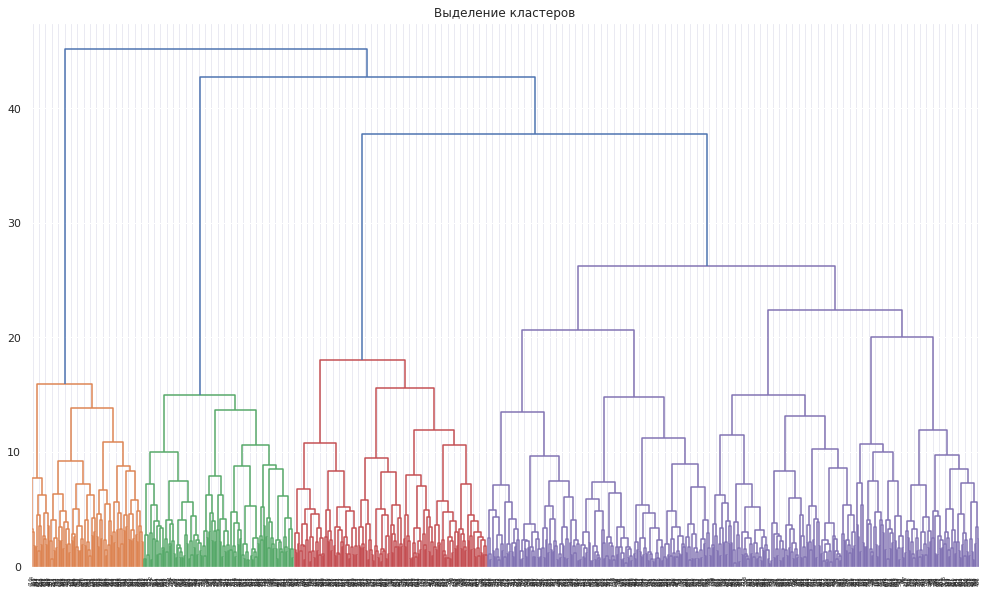

In [18]:
linked = linkage(X_test_st, method = 'ward') 

plt.figure(figsize=(17, 10))  
dendrogram(linked, orientation='top')
plt.title('Выделение кластеров')
plt.show() 

***Вывод*** Получннный график исходя из цветов предлагает нам делить данные на 4 кластера, но визуально видим, что можно поделить и на 5-6 кластеров. Для дальнейшего алгоритма KMeans возьмем 5 кластеров. 

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Исходя из графика выше мы выбрали число кластеров = 5.

In [19]:
km = KMeans(n_clusters=5, random_state=0)

x_sc = scaler.fit_transform(data.drop(['churn','month_to_end_contract',\
                                       'avg_class_frequency_total'], axis=1))

labels = km.fit_predict(x_sc)
data['cluster_km'] = labels

display('Количество элементов по кластерам', data['cluster_km'].value_counts())

'Количество элементов по кластерам'

2    1064
3    1007
0     985
1     558
4     386
Name: cluster_km, dtype: int64

***Вывод:*** Кластеры получены, интересно, что они разного размера, но в целом данных в кластерах должно быть достаточно: по нескольку сотен строк в каждом для анализа

<div class="alert bg-primary"> <b>Комментарий студента:</b>
    Так и есть, дописал)
</div>

Посмотрим на средние значения признаков для кластеров

In [20]:
data.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1).groupby('cluster_km')\
                                        .mean().sort_values(by='churn')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,
3,0.53,1.00,0.38,0.01,1.00,6.21,0.54,30.70,176.26,5.42,2.32,0.01
0,0.50,1.00,0.89,1.00,1.00,6.92,0.52,29.61,153.42,4.28,1.92,0.12
4,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,3.94,1.72,0.27
1,0.50,0.00,0.49,0.08,1.00,2.99,0.23,28.68,137.13,2.97,1.60,0.40
2,0.50,1.00,0.22,0.07,1.00,2.01,0.28,27.58,119.34,1.92,1.20,0.56


***Вывод:*** Что можем заметить:
* кластеры 0 и 3 имеют очень низкий отток
* самую большую среднюю длительность абонемента (lifetime) имеют кластер 0 и 3
* следующие величины сортируют кластеры в противоположном порядке в стравнении с сортировкой по оттоку: lifetime, avg_additional_charges_total, avg_class_frequency_current_month. Соответственно чем больше их значения тем меньше вероятность оттока.

Построим распределения признаков для кластеров

'Распределения непрерывнх признаков для кластеров'

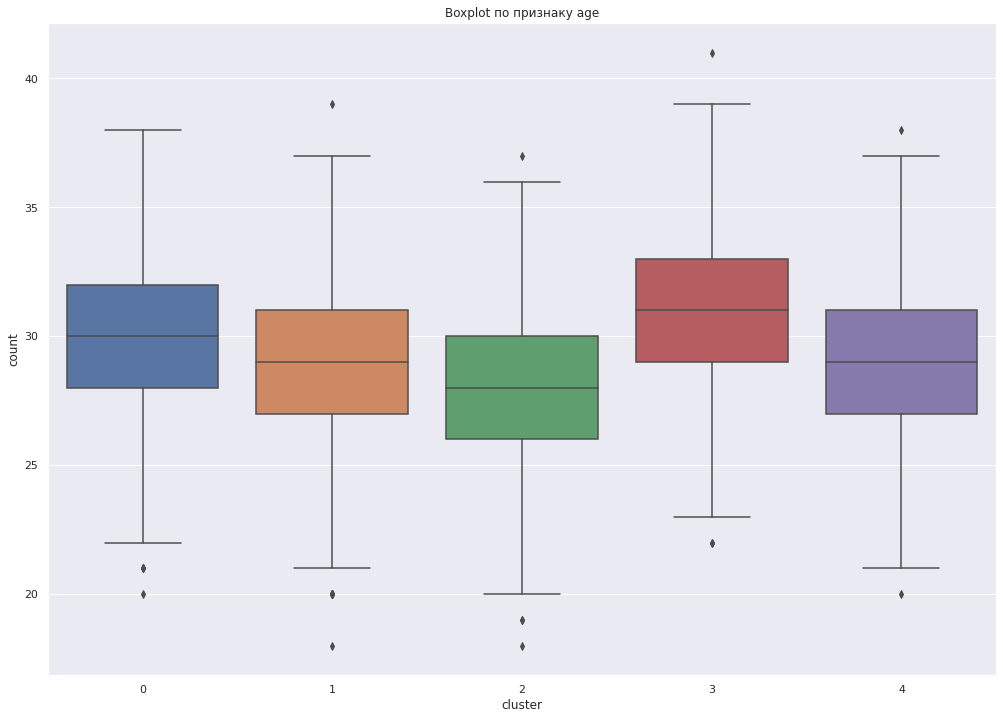

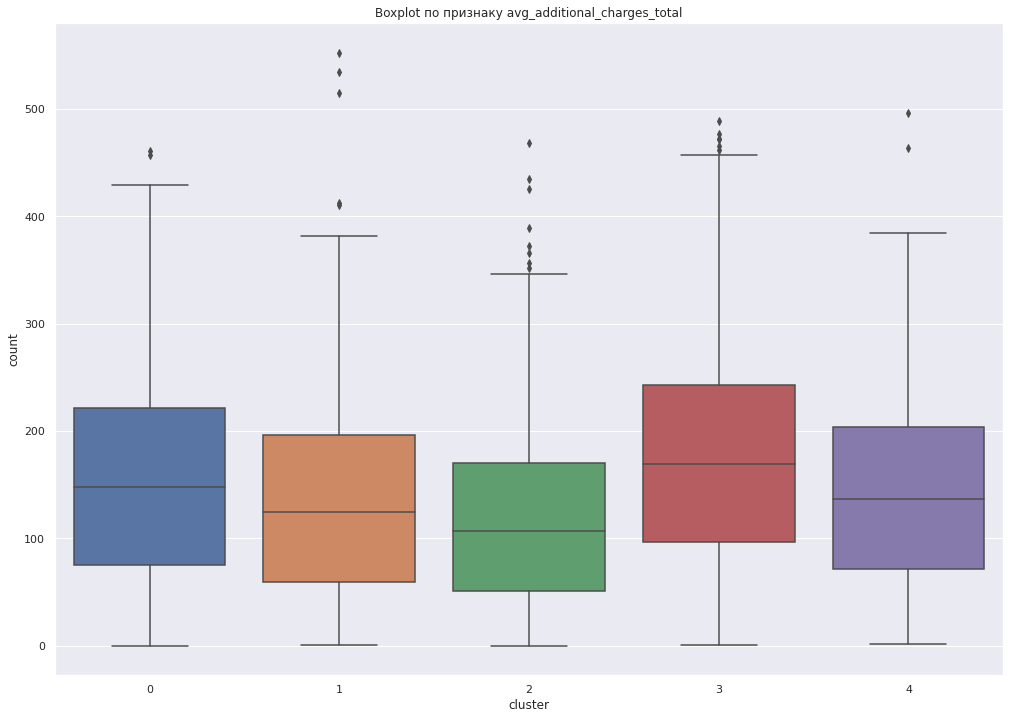

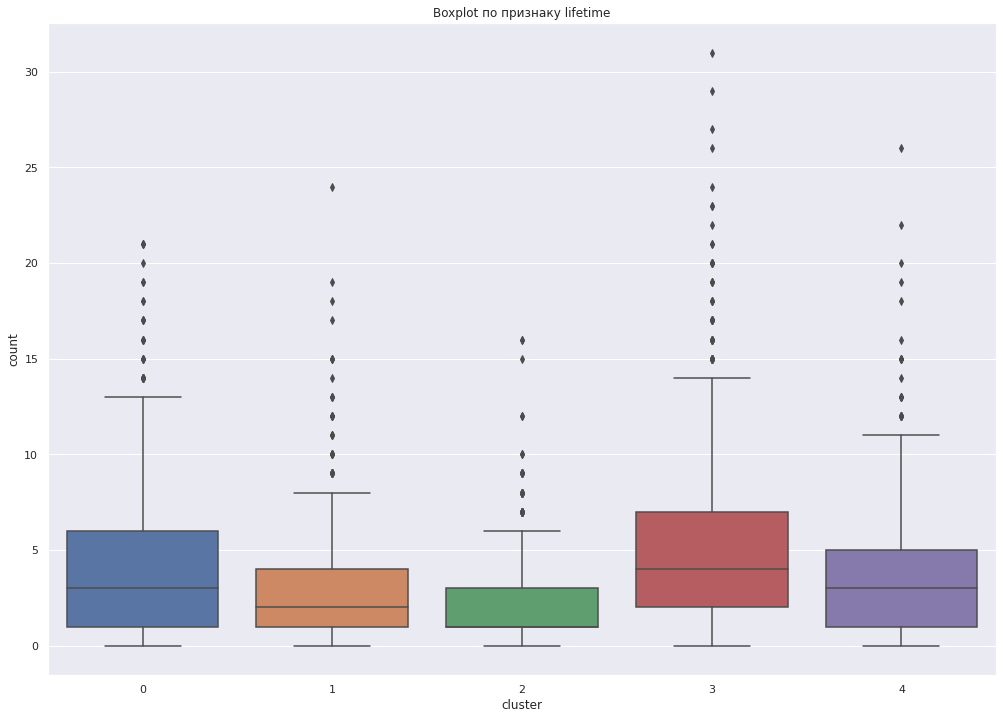

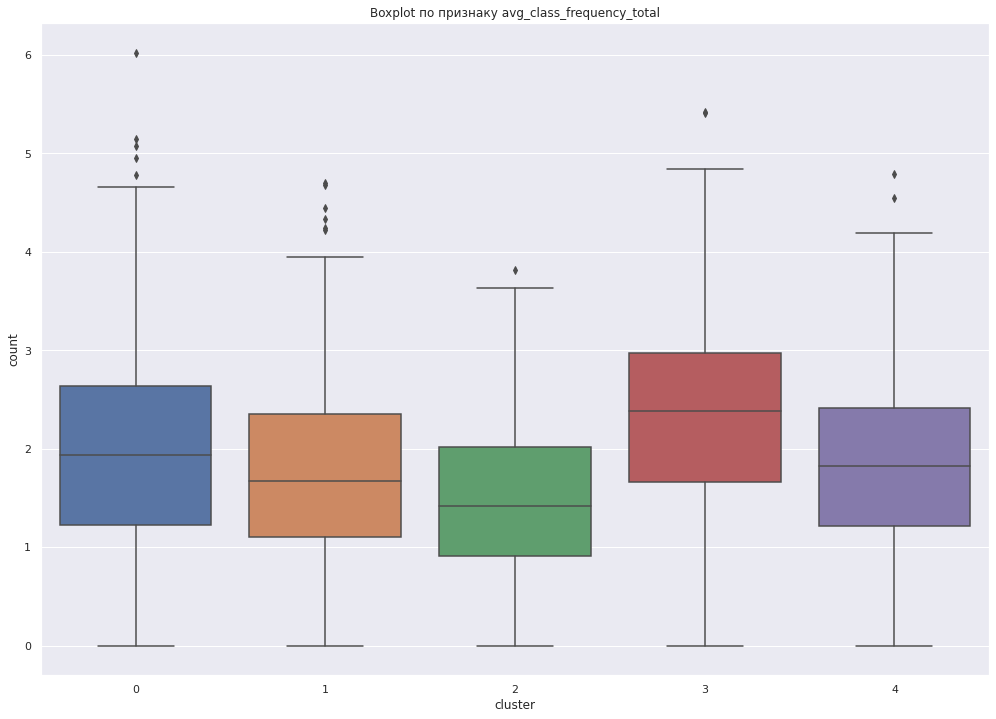

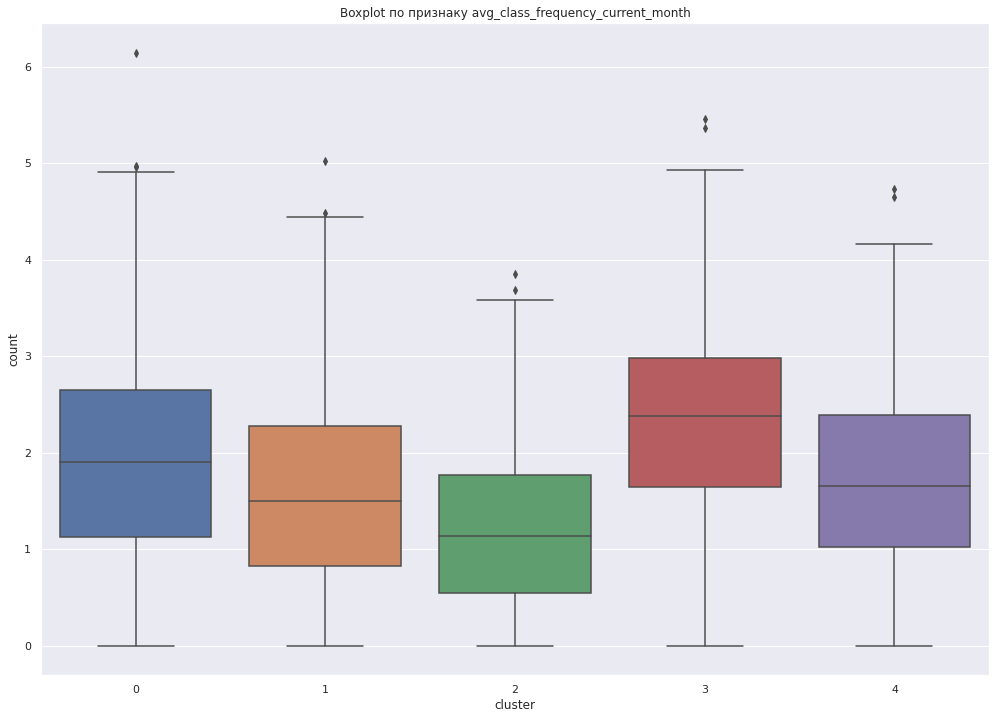

In [21]:
display('Распределения непрерывнх признаков для кластеров')

for col in continuous_cols:    
    plt.figure(figsize=(17,12))
    sns.boxplot(data=data, x=data['cluster_km'], y=col)   
    plt.title('Boxplot по признаку ' + col)    
    plt.xlabel('cluster')
    plt.ylabel('count')
    plt.show()

***Вывод:*** 
* У 3 и 0 кластеров по возрасту нижние и средние значения находятся выше остальных
* у 3 и 0 кластеров o	'Avg_additional_charges_total' межквартильный диапазон самый большой а также его границы находятся выше других кластеров. А у кластера 2 больше всех выбросов.
* То же самое касается lifetime
* По 'avg_class_frequency_current_month' и 'avg_class_frequency_total' в кластере 3 нижний квартиль находится даже выше верхнего квартиля всех остальных кластеров

'Распределения дискретных признаков для кластеров'

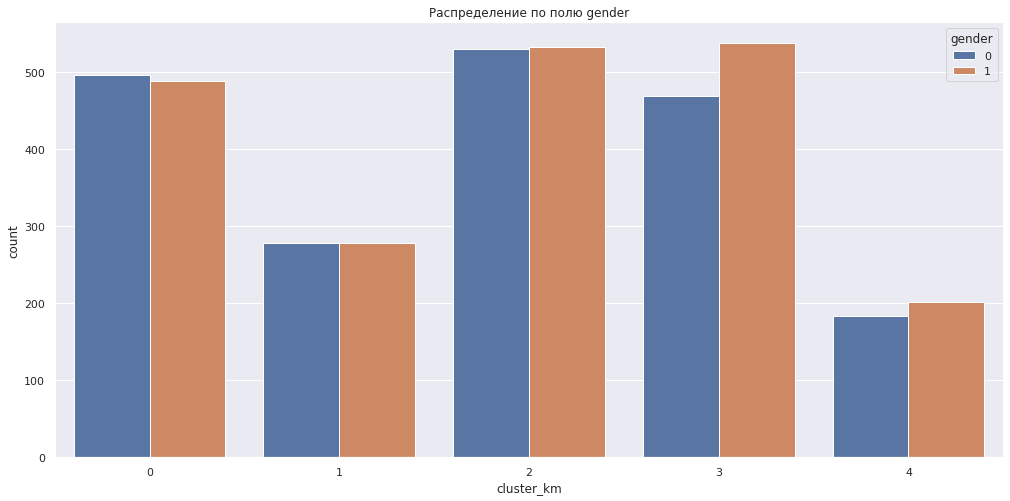

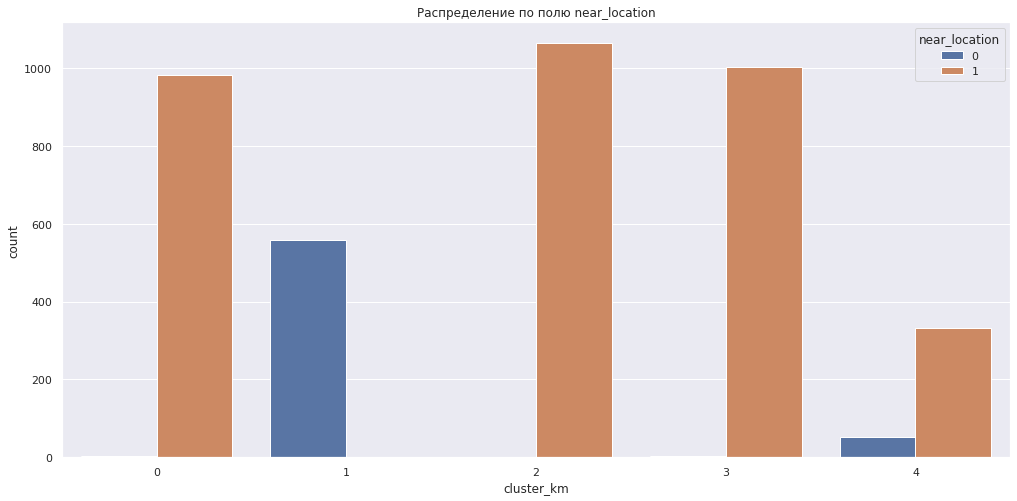

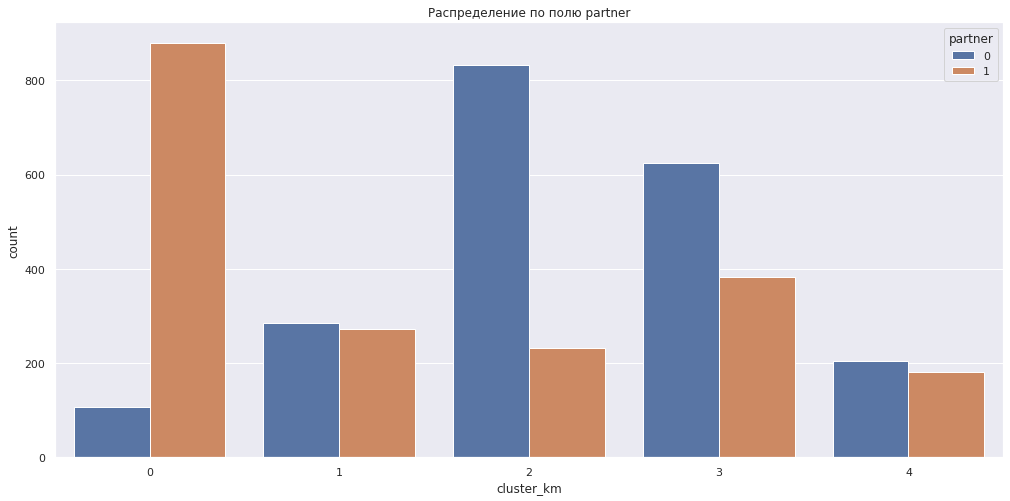

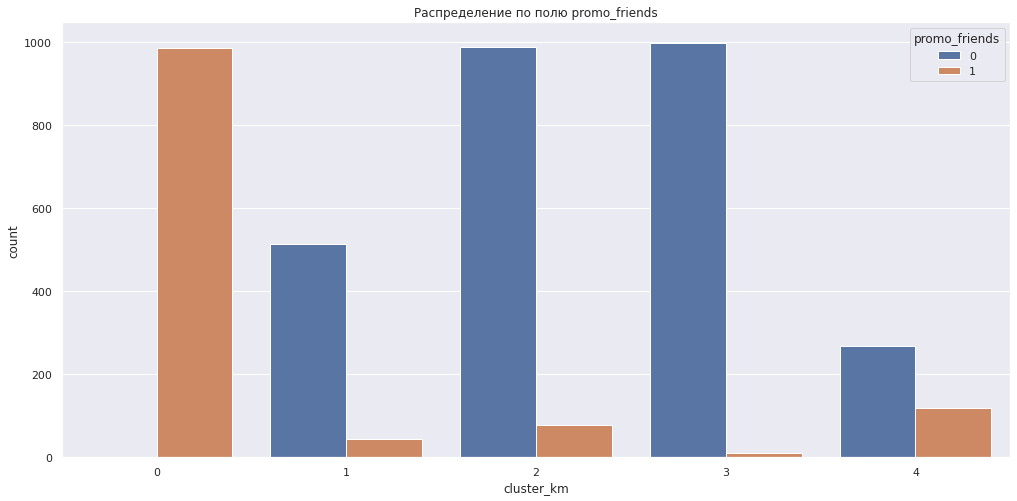

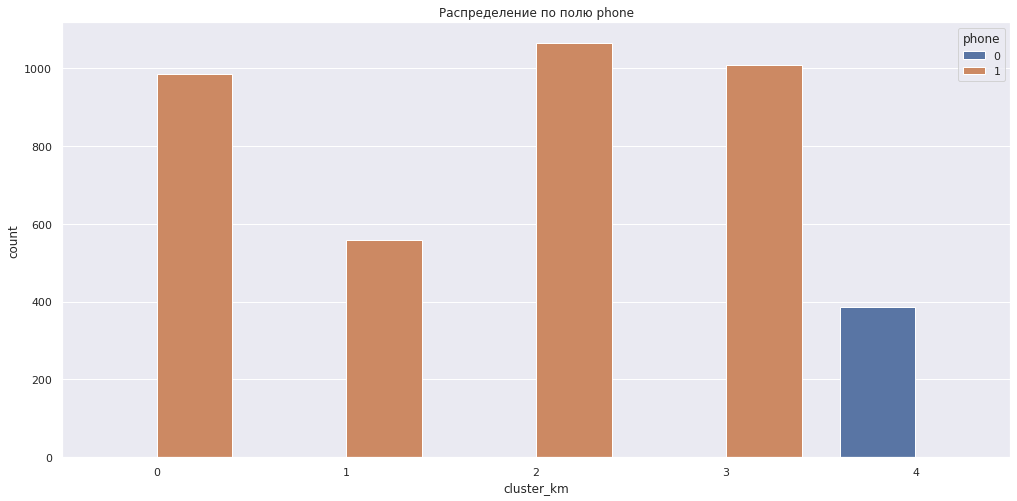

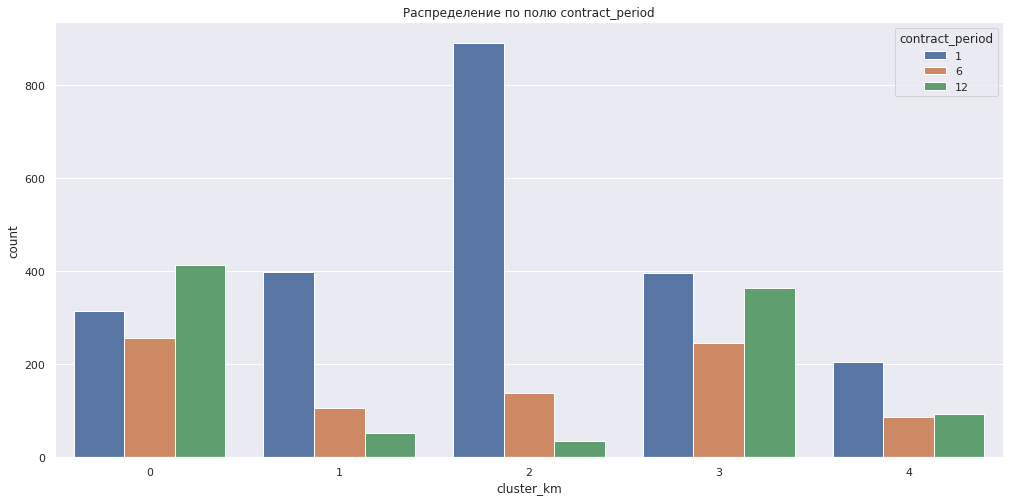

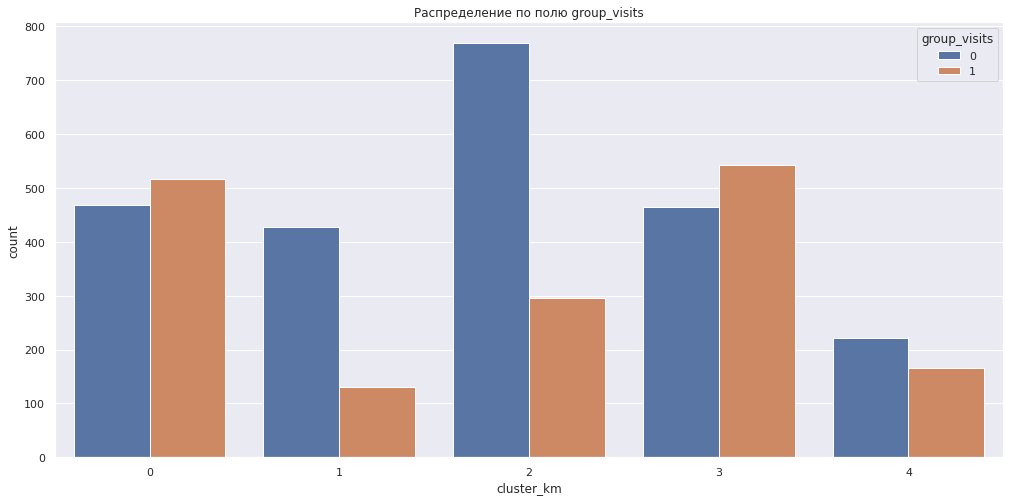

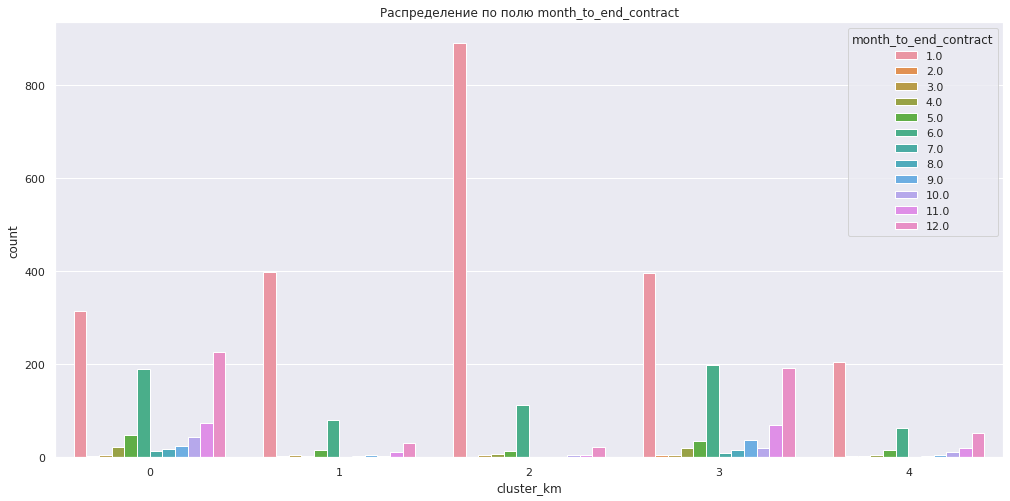

In [22]:
display('Распределения дискретных признаков для кластеров')

for col in discrete_cols:
    plt.figure(figsize=(17,8))
    plt.title('Распределение по полю ' + col)
    plt.legend(sorted(data[col].unique()), title = col)
    sns.countplot(x='cluster_km', hue=col, data=data)

***Выводы:***
* нулевые значения 'Near_Location' почти все попали в кластер 4.
* в кластере 0 почти все клиенты являются сотрудниками компании-партнёра клуба
* по полю promo_friends = 1 основная масса пользователей оказалась в кластере 0. 
* все клиенты без контактного телефона оказались в кластере 2
* абонемент на месяц сильно преобладает над другими в кластере 2, а вот в кластере 0 преобладает абонемент на год
* групповых занятий в кластерах 2 и 4 значительно меньше чем негрупповых
* срок до окончания везде преобладает на месяц, кроме кластера 1: в нем не сильно различается количество клиентов с оставшимся сроком 1, 6, 12


Для каждого полученного кластера посчитаем долю оттока 

In [23]:
df = pd.DataFrame({'cluster' :  data['cluster_km'].unique(), \
                   'churn_ratio' : data.query('churn == 1').groupby('cluster_km')['churn'].count() /\
                   data.groupby('cluster_km')['churn'].count()})


df.sort_values(by='churn_ratio', ascending=False)

,cluster,churn_ratio
cluster_km,,
2,2,0.56
1,3,0.40
4,1,0.27
0,4,0.12
3,0,0.01


***Вывод*** Вышли те же значения, что и по среднему на кластер

**Вывод по шагу**
Построили дендрограмму, спрогнозировали кластеры методом K-Means, изучили кластеры по среднм значениям признаков, построили и изучили  графики распределения признаков

<a id='summary'></a>
## Вывод

**Заново выпишем все выводы, сделанные на предыдущих шагах:**


Средние значения признаков в двух группах
* самые разнящиеся параметры у клиентов ушедших в отток и оставшихся: длительность текущего абонемента, срок до окончания текущего действующего абонемента, время с момента первого обращения в фитнес-центр, а также запись в клуб по акции «приведи друга». 

Столбчатые гистограммы для столбцов с дискретными величинами:
* сотрудники компании-партнёра клуба реже уходят в отток
* самый большой отток (почти половина) у тех кто заключил контракт только на месяц, и практически отсутствует у тех кто заключил на год.
* по групповым занятиям отток значительно меньше у тех кто их посещает
* когда срок до окончания текущего действующего абонемента - 1 месяц шанс отвалиться максимальный. Похоже это напрямую зависит от контракта на месяц.

Гистограммы для столбцов с непрерывными величинами
* при приближении к 30 летнему возрасту количество остающихся клиентов перевешивает уходящих и чем старше тем больше остающихся
* больше всего уходят клиенты в самый 1й месяц, в 2раза меньше во 2й, а вот те кто отзанимался больше 6 месяцев почти "не имеют шансов" покинуть наш фитнес-центр
* по средней частоте посещений: число остающихся начинает значительно сильнее перевешивать от 2,5 посещений и выше в неделю за все время
* по средней частоте посещений за предыдущий месяц: больше всего отваливаются те, кто посетил меньше 2х раз

Средние значения признаков для кластеров
* кластеры 0 и 3 имеют очень низкий отток
* самую большую среднюю длительность абонемента (lifetime) имеют кластер 0 и 3
* следующие величины сортируют кластеры в противоположном порядке в стравнении с сортировкой по оттоку: lifetime, avg_class_frequency_total, avg_class_frequency_current_month. Соответственно чем больше их значения тем меньше вероятность оттока.

Распределения непрерывнх признаков для кластеров
* У 3 и 0 кластеров по возрасту нижние и средние значения находятся выше остальных
* у 3 и 0 кластеров o 'Avg_additional_charges_total' межквартильный диапазон самый большой а также его границы находятся выше других кластеров. А у кластера 2 больше всех выбросов.
* То же самое касается lifetime
* По 'avg_class_frequency_current_month' и 'avg_class_frequency_total' в кластере 3 нижний квартиль находится даже выше верхнего квартиля всех остальных кластеров

Распределения дискретных признаков для кластеров

* нулевые значения 'Near_Location' почти все попали в кластер 4.
* в кластере 0 почти все клиенты являются сотрудниками компании-партнёра клуба
* по полю promo_friends = 1 основная масса пользователей оказалась в кластере 0.
* все клиенты без контактного телефона оказались в кластере 2
* абонемент на месяц сильно преобладает над другими в кластере 2, а вот в кластере 0 преобладает абонемент на год
* групповых занятий в кластерах 2 и 4 значительно меньше чем негрупповых
* срок до окончания везде преобладает на месяц, кроме кластера 1: в нем не сильно различается количество клиентов с оставшимся сроком 1, 6, 12

**Подытожим выводы**

*Вероятней всего останутся те кто:*
* являются сотрудниками компании-партнёра клуба
* заключили контракт на год
* посещают групповые занятия
* имеют возраст от 30 лет и выше
* занимаются больше 6 месяцев
* имеют больше 2х посещений в неделю в среднем за последний месяц (и за все время тоже) - большое влияние
* пришли по акции «приведи друга» 
* часто пользуются дополнительными услугами

*Вероятней всего уйдут в отток те кто:*
* заключили контракт только на месяц
* посетили меньше 2х раз за последнюю неделю
* не оставили контактный телефон
* имеют возраст значительно меньше 30
* пришли самолично, без акции "приведи друга" или от компании-партнёра 
* не посещают групповые занятия
и сделают они это скорее всего в 1й месяц

**Рекоммендации по удержанию и взаимодействию с клиентами**
* чаще проводить групповые занятия, агитировать на их посещение
* делать скидки при записи сразу на срок от 6 мес
* рассылать предложения всем компаниям-партнерам
* расширить/улучшить дополнительные услуги